## Tools

In [1]:
!pip install numexpr

In [1]:
import math
import re
from typing import List, Optional

import numexpr
from langchain.chains.openai_functions import create_structured_output_runnable
from helpers.structured_output_runnable_ollama_functions import create_structured_output_runnable_custom
from langchain_community.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama

from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import StructuredTool

_MATH_DESCRIPTION = (
    "math(problem: str, context: Optional[list[str]]) -> float:\n"
    " - Solves the provided math problem.\n"
    ' - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n'
    " - You cannot calculate multiple expressions in one call. For instance, `math('1 + 3, 2 + 4')` does not work. "
    "If you need to calculate multiple expressions, you need to call them separately like `math('1 + 3')` and then `math('2 + 4')`\n"
    " - Minimize the number of `math` actions as much as possible. For instance, instead of calling "
    '2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), '
    'you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n'
    # Context specific rules below
    " - You can optionally provide a list of strings as `context` to help the agent solve the problem. "
    "If there are multiple contexts you need to answer the question, you can provide them as a list of strings.\n"
    " - `math` action will not see the output of the previous actions unless you provide it as `context`. "
    "You MUST provide the output of the previous actions as `context` if you need to do math on it.\n"
    " - You MUST NEVER provide `search` type action's outputs as a variable in the `problem` argument. "
    "This is because `search` returns a text blob that contains the information about the entity, not a number or value. "
    "Therefore, when you need to provide an output of `search` action, you MUST provide it as a `context` argument to `math` action. "
    'For example, 1. search("Barack Obama") and then 2. math("age of $1") is NEVER allowed. '
    'Use 2. math("age of Barack Obama", context=["$1"]) instead.\n'
    " - When you ask a question about `context`, specify the units. "
    'For instance, "what is xx in height?" or "what is xx in millions?" instead of "what is xx?"\n'
)


_SYSTEM_PROMPT = """Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.

Question: ${{Question with math problem.}}
```text
${{single line mathematical expression that solves the problem}}
```
...numexpr.evaluate(text)...
```output
${{Output of running the code}}
```
Answer: ${{Answer}}

Begin.

Question: What is 37593 * 67?
ExecuteCode({{code: "37593 * 67"}})
...numexpr.evaluate("37593 * 67")...
```output
2518731
```
Answer: 2518731

Question: 37593^(1/5)
ExecuteCode({{code: "37593**(1/5)"}})
...numexpr.evaluate("37593**(1/5)")...
```output
8.222831614237718
```
Answer: 8.222831614237718
"""

_ADDITIONAL_CONTEXT_PROMPT = """The following additional context is provided from other functions.\
    Use it to substitute into any ${{#}} variables or other words in the problem.\
    \n\n${context}\n\nNote that context varibles are not defined in code yet.\
You must extract the relevant numbers and directly put them in code."""


class ExecuteCode(BaseModel):
    """The input to the numexpr.evaluate() function."""

    reasoning: str = Field(
        ...,
        description="The reasoning behind the code expression, including how context is included, if applicable.",
    )

    code: str = Field(
        ...,
        description="The simple code expresssion to execute by numexpr.evaluate().",
    )


def _evaluate_expression(expression: str) -> str:
    try:
        local_dict = {"pi": math.pi, "e": math.e}
        output = str(
            numexpr.evaluate(
                expression.strip(),
                global_dict={},  # restrict access to globals
                local_dict=local_dict,  # add common mathematical functions
            )
        )
    except Exception as e:
        raise ValueError(
            f'Failed to evaluate "{expression}". Raised error: {repr(e)}.'
            " Please try again with a valid numerical expression"
        )

    # Remove any leading and trailing brackets from the output
    return re.sub(r"^\[|\]$", "", output)


def get_math_tool(llm: ChatOllama):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", _SYSTEM_PROMPT),
            ("user", "{problem}"),
            MessagesPlaceholder(variable_name="context", optional=True),
        ]
    )
    
    extractor = create_structured_output_runnable_custom(ExecuteCode, llm, prompt)
    # extractor = create_structured_output_runnable(ExecuteCode, llm, prompt, mode='openai-functions')

    def calculate_expression(
        problem: str,
        context: Optional[List[str]] = None,
        config: Optional[RunnableConfig] = None,
    ):
        chain_input = {"problem": problem}
        if context:
            context_str = "\n".join(context)
            if context_str.strip():
                context_str = _ADDITIONAL_CONTEXT_PROMPT.format(
                    context=context_str.strip()
                )
                chain_input["context"] = [SystemMessage(content=context_str)]
        code_model = extractor.invoke(chain_input, config)
        print(code_model)
        try:
            return _evaluate_expression(code_model.code)
        except Exception as e:
            return repr(e)

    return StructuredTool.from_function(
        name="math",
        func=calculate_expression,
        description=_MATH_DESCRIPTION,
    )


In [10]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
# from LLMCompiler.math_tools import get_math_tool



from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model='mistral:7b-instruct-v0.2-q8_0')


search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

calculate = get_math_tool(llm)  

tools = [search, calculate]

In [11]:
from langchain.globals import set_debug

set_debug(True)
from langchain.globals import set_verbose

set_verbose(True)

In [13]:
calculate.invoke(
    {
        "problem": "What is 5 + 5?",
        # "context": ["The tempreature of sf is 33 degrees"],
    }
)

[tool/start] [1:tool:math] Entering Tool run with input:
"{'problem': 'What is 5 + 5?'}"
[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "problem": "What is 5 + 5?"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "problem": "What is 5 + 5?"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [1:chain:RunnableSequence > 3:llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "System: Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.\n\nQuestion: ${Question with math problem.}\n```text\n${single line mathematical expression that solves the problem}\n```\n...numexpr.evaluate(text)...\n```output\n${Output of running the code}\n```\nAnswer: ${Answer}\n\nBegin.\n\nQuestion: What is 37593 * 67?\nExecuteCode({c

KeyboardInterrupt: 

In [13]:
calculate

StructuredTool(name='math', description='math(problem: str, context: Optional[List[str]] = None, config: Optional[langchain_core.runnables.config.RunnableConfig] = None) - math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n - You can optionally provide a list of strings as `context` to hel

#### math Tools

In [14]:
import math
import re
from typing import List, Optional

import numexpr
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_community.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama

from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import StructuredTool

_MATH_DESCRIPTION = (
    "math(problem: str, context: Optional[list[str]]) -> float:\n"
    " - Solves the provided math problem.\n"
    ' - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n'
    " - You cannot calculate multiple expressions in one call. For instance, `math('1 + 3, 2 + 4')` does not work. "
    "If you need to calculate multiple expressions, you need to call them separately like `math('1 + 3')` and then `math('2 + 4')`\n"
    " - Minimize the number of `math` actions as much as possible. For instance, instead of calling "
    '2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), '
    'you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n'
    # Context specific rules below
    " - You can optionally provide a list of strings as `context` to help the agent solve the problem. "
    "If there are multiple contexts you need to answer the question, you can provide them as a list of strings.\n"
    " - `math` action will not see the output of the previous actions unless you provide it as `context`. "
    "You MUST provide the output of the previous actions as `context` if you need to do math on it.\n"
    " - You MUST NEVER provide `search` type action's outputs as a variable in the `problem` argument. "
    "This is because `search` returns a text blob that contains the information about the entity, not a number or value. "
    "Therefore, when you need to provide an output of `search` action, you MUST provide it as a `context` argument to `math` action. "
    'For example, 1. search("Barack Obama") and then 2. math("age of $1") is NEVER allowed. '
    'Use 2. math("age of Barack Obama", context=["$1"]) instead.\n'
    " - When you ask a question about `context`, specify the units. "
    'For instance, "what is xx in height?" or "what is xx in millions?" instead of "what is xx?"\n'
)


_SYSTEM_PROMPT = """Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.

Question: ${{Question with math problem.}}
```text
${{single line mathematical expression that solves the problem}}
```
...numexpr.evaluate(text)...
```output
${{Output of running the code}}
```
Answer: ${{Answer}}

Begin.

Question: What is 37593 * 67?
ExecuteCode({{code: "37593 * 67"}})
...numexpr.evaluate("37593 * 67")...
```output
2518731
```
Answer: 2518731

Question: 37593^(1/5)
ExecuteCode({{code: "37593**(1/5)"}})
...numexpr.evaluate("37593**(1/5)")...
```output
8.222831614237718
```
Answer: 8.222831614237718
"""

_ADDITIONAL_CONTEXT_PROMPT = """The following additional context is provided from other functions.\
    Use it to substitute into any ${{#}} variables or other words in the problem.\
    \n\n${context}\n\nNote that context varibles are not defined in code yet.\
You must extract the relevant numbers and directly put them in code."""


class ExecuteCode(BaseModel):
    """The input to the numexpr.evaluate() function."""

    reasoning: str = Field(
        ...,
        description="The reasoning behind the code expression, including how context is included, if applicable.",
    )

    code: str = Field(
        ...,
        description="The simple code expresssion to execute by numexpr.evaluate().",
    )


In [15]:

def _evaluate_expression(expression: str) -> str:
    try:
        local_dict = {"pi": math.pi, "e": math.e}
        output = str(
            numexpr.evaluate(
                expression.strip(),
                global_dict={},  # restrict access to globals
                local_dict=local_dict,  # add common mathematical functions
            )
        )
    except Exception as e:
        raise ValueError(
            f'Failed to evaluate "{expression}". Raised error: {repr(e)}.'
            " Please try again with a valid numerical expression"
        )

    # Remove any leading and trailing brackets from the output
    return re.sub(r"^\[|\]$", "", output)


In [6]:
def get_math_tool(llm):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", _SYSTEM_PROMPT),
            ("user", "{problem}"),
            MessagesPlaceholder(variable_name="context", optional=True),
        ]
    )
    extractor = create_structured_output_runnable(ExecuteCode, llm, prompt, 
                                                  mode='openai-functions',
                                                  enforce_function_usage=True)
    
    print(extractor)

    def calculate_expression(
        problem: str,
        context: Optional[List[str]] = None,
        config: Optional[RunnableConfig] = None,
    ):
        chain_input = {"problem": problem}
        if context:
            context_str = "\n".join(context)
            if context_str.strip():
                context_str = _ADDITIONAL_CONTEXT_PROMPT.format(
                    context=context_str.strip()
                )
                chain_input["context"] = [SystemMessage(content=context_str)]
        print(chain_input)
        code_model = extractor.invoke(chain_input, config)
        print(code_model)
        
        try:
            return _evaluate_expression(code_model.code)
        except Exception as e:
            return repr(e)

    return StructuredTool.from_function(
        name="math",
        func=calculate_expression,
        description=_MATH_DESCRIPTION,
    )


In [7]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
# from LLMCompiler.math_tools import get_math_tool

from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K', temperature=0.1)

from langchain_experimental.llms.ollama_functions import OllamaFunctions

ollama_func = OllamaFunctions(llm = llm)


search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

calculate = get_math_tool(ollama_func)  

tools = [search, calculate]

NameError: name 'ChatPromptTemplate' is not defined

In [8]:
calculate.invoke(
    {
        "problem": "What's the temp of sf + 5?",
        "context": ["Thet empreature of sf is 33 degrees"],
    }
)

KeyboardInterrupt: 

In [34]:
llm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K', temperature=0.1)

ollama_func = OllamaFunctions(llm = llm)


extractor = create_structured_output_runnable(ExecuteCode, ollama_func, prompt)

In [35]:
extractor

ChatPromptTemplate(input_variables=['input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Extract information about any dogs mentioned in the user input.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])
| RunnableBinding(bound=OllamaFunctions(llm=ChatOllama(model='mistral:7b-instruct-v0.2-q6_K', temperature=0.1), tool_system_prompt_template='You have access to the following tools:\n\n{tools}\n\nYou must always select one of the above tools and respond with only a JSON object matching the following schema:\n\n{{\n  "tool": <name of the selected tool>,\n  "tool_input": <parameters for the selected tool, matching the tool\'s JSON schema>\n}}\n'), kwargs={'functions': [{'name': '_OutputFormatter', 'description': 'Output formatter. Should always be used to format your response to the user.', 'parameters': {'type': 'object', 'properties': {'output': {'description': 'The input to the numexpr.ev

In [38]:
input = {'problem': "What's the temp of sf + 5?", 'context': ['Thet empreature of sf is 33 degrees']}

In [5]:
extractor.invoke({'input': "What's the temp of sf + 5?", 'context': ['Thet empreature of sf is 33 degrees']})

NameError: name 'extractor' is not defined

funcutions example

In [33]:

from typing import Optional

from langchain.chains import create_structured_output_runnable
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Dog(BaseModel):
    '''Identifying information about a dog.'''

    name: str = Field(..., description="The dog's name")
    color: str = Field(..., description="The dog's color")
    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

llm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K', temperature=0.1)

# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
ollama_func = OllamaFunctions(llm = llm)


structured_llm = create_structured_output_runnable(Dog, ollama_func, mode="openai-functions")
system = '''Extract information about any dogs mentioned in the user input.'''
prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "{input}"),]
)
chain = prompt | structured_llm
chain.invoke({"input": "Harry was a chubby brown beagle who loved chicken"})
# -> Dog(name="Harry", color="brown", fav_food="chicken")

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Harry was a chubby brown beagle who loved chicken"
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "input": "Harry was a chubby brown beagle who loved chicken"
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [1:chain:RunnableSequence > 3:llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "System: Extract information about any dogs mentioned in the user input.\nHuman: Harry was a chubby brown beagle who loved chicken"
  ]
}
[llm/start] [1:chain:RunnableSequence > 4:llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "System: You have access to the following tools:\n\n[\n  {\n    \"name\": \"_OutputFormatter\",\n    \"description\": \"Output formatter. Should always be used to format your response to the user.\",\n    \"parameters\

Dog(name='Harry', color='brown', fav_food='chicken')

In [45]:
from langchain.chains import create_extraction_chain

# Schema
schema = {
    "properties": {
        "name": {"type": "string"},
        "height": {"type": "integer"},
        "hair_color": {"type": "string"},
    },
    "required": ["name", "height"],
}

# Input
input = """Alex is 5 feet tall. Claudia is 1 feet taller than Alex and jumps higher than him. Claudia is a brunette and Alex is blonde."""

# Run chain
llm = OllamaFunctions(model="mistral:7b-instruct-v0.2-q6_K", temperature=0)
chain = create_extraction_chain(schema, llm)
chain.run(input)

/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


[chain/start] [1:chain:LLMChain] Entering Chain run with input:
{
  "input": "Alex is 5 feet tall. Claudia is 1 feet taller than Alex and jumps higher than him. Claudia is a brunette and Alex is blonde."
}
[llm/start] [1:chain:LLMChain > 2:llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "Human: Extract and save the relevant entities mentioned in the following passage together with their properties.\n\nOnly extract the properties mentioned in the 'information_extraction' function.\n\nIf a property is not present and is not required in the function parameters, do not include it in the output.\n\nPassage:\nAlex is 5 feet tall. Claudia is 1 feet taller than Alex and jumps higher than him. Claudia is a brunette and Alex is blonde."
  ]
}
[llm/start] [1:chain:LLMChain > 3:llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "System: You have access to the following tools:\n\n[\n  {\n    \"name\": \"information_extraction\",\n    \"description\": \"Extracts

[{'name': 'Alex', 'height': 5}, {'name': 'Claudia', 'height': 6}]

In [ ]:
lass Dog(BaseModel):
    '''Identifying information about a dog.'''

    name: str = Field(..., description="The dog's name")
    color: str = Field(..., description="The dog's color")
    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

In [ ]:
"{'problem': "What's the temp of sf + 5?", 'context': ['Thet empreature of sf is 33 degrees']}"


In [ ]:
{'problem': "What's the temp of sf + 5?", 'context': [SystemMessage(content='The following additional context is provided from other functions.    Use it to substitute into any ${#} variables or other words in the problem.    \n\n$Thet empreature of sf is 33 degrees\n\nNote that context varibles are not defined in code yet.You must extract the relevant numbers and directly put them in code.')]}

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field


_SYSTEM_PROMPT = """Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.

Question: ${{Question with math problem.}}
```text
${{single line mathematical expression that solves the problem}}
```
...numexpr.evaluate(text)...
```output
${{Output of running the code}}
```
Answer: ${{Answer}}

Begin.

Question: What is 37593 * 67?
ExecuteCode({{code: "37593 * 67"}})
...numexpr.evaluate("37593 * 67")...
```output
2518731
```
Answer: 2518731

Question: 37593^(1/5)
ExecuteCode({{code: "37593**(1/5)"}})
...numexpr.evaluate("37593**(1/5)")...
```output
8.222831614237718
```
Answer: 8.222831614237718
"""


class ExecuteCode(BaseModel):
    """The input to the numexpr.evaluate() function."""

    reasoning: str = Field(
        ...,
        description="The reasoning behind the code expression, including how context is included, if applicable.",
    )

    code: str = Field(
        ...,
        description="The simple code expresssion to execute by numexpr.evaluate().",
    )

In [17]:

from typing import Optional

from langchain.chains import create_structured_output_runnable
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_experimental.llms.ollama_functions import OllamaFunctions

class Dog(BaseModel):
    '''Identifying information about a dog.'''

    name: str = Field(..., description="The dog's name")
    color: str = Field(..., description="The dog's color")
    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

# llm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K', temperature=0.1)

# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
ollama_func = OllamaFunctions(model='mistral:7b-instruct-v0.2-q6_K')

prompt = ChatPromptTemplate.from_messages(
        [
            ("system", _SYSTEM_PROMPT),
            ("user", "{problem}"),
            MessagesPlaceholder(variable_name="context", optional=True),
        ]
    )

structured_llm = create_structured_output_runnable(ExecuteCode, ollama_func, mode="openai-functions", prompt=prompt)

# system = '''Extract information about any dogs mentioned in the user input.'''
# prompt = ChatPromptTemplate.from_messages(
#     [("system", system), ("human", "{input}"),]
# )
# extractor = prompt | structured_llm
structured_llm.invoke({
        "problem": "What's the temp of sf + 5?",
        "context": ["The tempreature of sf is 33 degrees"],
    })
# -> Dog(name="Harry", color="brown", fav_food="chicken")

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "problem": "What's the temp of sf + 5?",
  "context": [
    "The tempreature of sf is 33 degrees"
  ]
}
[chain/start] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "problem": "What's the temp of sf + 5?",
  "context": [
    "The tempreature of sf is 33 degrees"
  ]
}
[chain/end] [1:chain:RunnableSequence > 2:prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [1:chain:RunnableSequence > 3:llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "System: Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.\n\nQuestion: ${Question with math problem.}\n```text\n${single line mathematical expression that solves the problem}\n```\n...numexpr.evaluate(text)...\n```output\n${Output of running the code}\n```\nAnswer: ${Answer}

KeyboardInterrupt: 

# Tools

In [11]:
!pip install --upgrade --quiet  duckduckgo-search
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=ed85b2014ae4896b034f4f5197634e87c0a96eaa75366d5eefd6153e7c3ed0ad
  Stored in directory: /home/amaithi/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [42]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

# Imported from the https://github.com/langchain-ai/langgraph/tree/main/examples/plan-and-execute repo
# from math_tools import get_math_tool


# _get_pass("TAVILY_API_KEY")
import os 
os.environ['TAVILY_API_KEY'] = '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'

# calculate = get_math_tool(llm='mistral:7b-instruct-v0.2-q6_K')

search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)


from langchain_community.tools import DuckDuckGoSearchRun
duck = DuckDuckGoSearchRun()

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


from langchain_core.pydantic_v1 import BaseModel, Field


api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)

class WikiInputs(BaseModel):
    """Inputs to the wikipedia tool."""

    query: str = Field(
        description="query to look up in Wikipedia, should be 3 or less words"
    )
    

wiki = WikipediaQueryRun(
    name="wikipedia_search",
    description="wikipedia_search - to search things in wikipedia",
    args_schema=WikiInputs,
    api_wrapper=api_wrapper,
    return_direct=True,
)


tools = [search, wiki]

In [43]:
wiki.name

'wikipedia_search'

# Plannaer

In [44]:
from typing import Sequence

from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)

from LLMCompiler.output_parser import LLMCompilerPlanParser, Task
from langchain import hub
from langchain_openai import ChatOpenAI


prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [48]:
tool_descriptions = "\n ".join(
        f"{i}. {tool.description}\n" for i, tool in enumerate(tools)
    )

planner_prompt = prompt.partial(
    replan="",
    num_tools=len(tools),
    tool_descriptions=tool_descriptions,
    )

print(planner_prompt)

input_variables=['messages'] input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} partial_variables={'replan': '', 'num_tools': 2, 'tool_descriptions': '0. tavily_search_results_json(query="the search query") - a search engine.\n\n 1. wikipedia_search - to search things in wikipedia\n'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['num_tools', 'tool_descriptions'], template="Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:\n{tool_descriptions}\n{num_tools}. join(): Collects and combines results from prior actions.\n\n - An LLM agent is called upon invoking join() to either finalize the user que

In [20]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i}. {tool.description}\n" for i, tool in enumerate(tools)
    )
    
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools),
        tool_descriptions=tool_descriptions,
    )
    print(planner_prompt.pretty_print())
    
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools),
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [21]:
from langchain_community.chat_models import ChatOllama

lllm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K')

planner = create_planner(lllm, tools, prompt)


================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [22]:
tools

[TavilySearchResults(description='tavily_search_results_json(query="the search query") - a search engine.', max_results=1),
 StructuredTool(name='math', description='math(problem: str, context: Optional[List[str]] = None, config: Optional[langchain_core.runnables.config.RunnableConfig] = None) - math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1"

In [23]:
example_question = "Where does pondicherry located?"

for task in planner.stream([HumanMessage(content=example_question)]):
    print(task["tool"], task["args"])
    print("---")

join ()
---
name='math' description='math(problem: str, context: Optional[List[str]] = None, config: Optional[langchain_core.runnables.config.RunnableConfig] = None) - math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n - You can optionally provide a list of strings as `context` to help th

# Task fetching Unit

In [24]:
from typing import Any, Union, Iterable, List, Tuple, Dict
from typing_extensions import TypedDict

from langchain_core.runnables import (
    chain as as_runnable,
)

from concurrent.futures import ThreadPoolExecutor, wait
import time


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    if isinstance(arg, str) and arg.startswith("$"):
        try:
            stripped = arg[1:].replace(".output", "").strip("{}")
            idx = int(stripped)
        except Exception:
            return str(arg)
        return str(observations[idx])
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(name=name, content=str(obs), additional_kwargs={"idx": k})
        for k, (name, obs) in new_observations.items()
    ]
    return tool_messages

In [25]:
import itertools


@as_runnable
def plan_and_schedule(messages: List[BaseMessage], config):
    tasks = planner.stream(messages, config)
    # Begin executing the planner immediately
    tasks = itertools.chain([next(tasks)], tasks)
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        },
        config,
    )
    return scheduled_tasks

In [26]:
tool_messages = plan_and_schedule.invoke([HumanMessage(content=example_question)])

In [27]:
tool_messages

[FunctionMessage(content='join', additional_kwargs={'idx': 1}, name='join')]

# Joiner

In [28]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.messages import AIMessage


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
# llm = ChatOpenAI(model="gpt-4-turbo-preview")
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_community.chat_models import ChatOllama

model = ChatOllama(model="mistral:7b-instruct-v0.2-q6_K")
llm = OllamaFunctions(llm=model)
from langchain.chains import create_extraction_chain

runnable = create_structured_output_runnable(JoinOutputs, llm, joiner_prompt)

In [29]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return response + [
            SystemMessage(
                content=f"Context from last attempt: {decision.action.feedback}"
            )
        ]
    else:
        return response + [AIMessage(content=decision.action.response)]


def select_recent_messages(messages: list) -> dict:
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break

        c = {"messages": selected[::-1]}
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

In [30]:
input_messages = [HumanMessage(content=example_question)] + tool_messages

In [31]:
input_messages

[HumanMessage(content='Where does pondicherry located?'),
 FunctionMessage(content='join', additional_kwargs={'idx': 1}, name='join')]

In [33]:
joiner.invoke(input_messages)

ValueError: Received unsupported message type for Ollama.

# Compose using LangGraph

In [72]:
from langgraph.graph import MessageGraph, END
from typing import Dict

graph_builder = MessageGraph()

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state: List[BaseMessage]):
    if isinstance(state[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    start_key="join",
    # Next, we pass in the function that will determine which node is called next.
    condition=should_continue,
)
graph_builder.set_entry_point("plan_and_schedule")
chain = graph_builder.compile()

question

In [74]:
for step in chain.stream([HumanMessage(content="What's the GDP of New York?")]):
    print(step)
    print("---")

{'plan_and_schedule': [FunctionMessage(content="ERROR(Failed to call wikipedia_search with args {}. Args resolved to {}. Error: ValidationError(model='WikiInputs', errors=[{'loc': ('query',), 'msg': 'field required', 'type': 'value_error.missing'}]))", additional_kwargs={'idx': 1}, name='wikipedia_search')]}
---


ValueError: Received unsupported message type for Ollama.

# Mar12 - LLM Compiler

### Part 1 Tools

In [2]:
!poetry add numepr


Could not find a matching version of package numepr


In [2]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()

from LLMCompiler.math_tools import get_math_tool

llm = OllamaFunctions(model='mistral:7b-instruct-v0.2-q8_0')

# calculate = get_math_tool(llm)

search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

# tools = [search, calculate]
tools = [search]

In [3]:
search

TavilySearchResults(description='tavily_search_results_json(query="the search query") - a search engine.', max_results=1)

In [3]:
calculate.invoke(
    {
        "problem": "What's the temp of sf + 5?",
        "context": ["Thet empreature of sf is 32 degrees"],
    }
)

KeyboardInterrupt: 

In [4]:
from typing import Sequence

from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)

from LLMCompiler.output_parser import LLMCompilerPlanParser, Task
from langchain import hub
# from langchain_openai import ChatOpenAI


prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())



================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [5]:
prompt

ChatPromptTemplate(input_variables=['messages', 'num_tools', 'tool_descriptions'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['num_tools', 'tool_descriptions'], template="Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:\n{tool_descriptions}\n{num_tools}. join(): Collects and combines results from prior actions.\n\n - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.\n - join should always be the last action in the plan, and will be called in two scenarios:\n   (a) if the ans

In [6]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f" {i}. {tool.description}\n" for i, tool in enumerate(tools)
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools),
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools),
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [7]:
from langchain_community.chat_models import ChatOllama

agent_llm = ChatOllama(model='mistral:7b-instruct-v0.2-q8_0')
# This is the primary "agent" in our application
planner = create_planner(agent_llm, tools, prompt)

In [8]:
# example_question = "What's the temperature in SF raised to the 3rd power?"

# for task in planner.stream([HumanMessage(content=example_question)]):
#     print(task["tool"], task["args"])
#     print("---")

# 3 Task fetching unit

In [8]:
from typing import Any, Union, Iterable, List, Tuple, Dict
from typing_extensions import TypedDict

from langchain_core.runnables import (
    chain as as_runnable,
)

from concurrent.futures import ThreadPoolExecutor, wait
import time


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    if isinstance(arg, str) and arg.startswith("$"):
        try:
            stripped = arg[1:].replace(".output", "").strip("{}")
            idx = int(stripped)
        except Exception:
            return str(arg)
        return str(observations[idx])
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(name=name, content=str(obs), additional_kwargs={"idx": k})
        for k, (name, obs) in new_observations.items()
    ]
    return tool_messages

In [9]:
import itertools


@as_runnable
def plan_and_schedule(messages: List[BaseMessage], config):
    tasks = planner.stream(messages, config)
    # Begin executing the planner immediately
    tasks = itertools.chain([next(tasks)], tasks)
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        },
        config,
    )
    return scheduled_tasks

Example

In [11]:
example_question = "What's the temperature in SF raised to the 3rd power?"
tool_messages = plan_and_schedule.invoke([HumanMessage(content=example_question)])

In [12]:
tool_messages

[FunctionMessage(content='ERROR(Failed to call math with args {\'problem\': "(${$0}.result[\'temp\'])**3", \'context\': None}. Args resolved to {\'problem\': "(${$0}.result[\'temp\'])**3", \'context\': \'None\'}. Error: ValidationError(model=\'mathSchema\', errors=[{\'loc\': (\'context\',), \'msg\': \'value is not a valid list\', \'type\': \'type_error.list\'}]))', additional_kwargs={'idx': 1}, name='math')]

# 4. Joiner

In [10]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chains.openai_functions import create_structured_output_runnable
from helpers.structured_output_runnable_ollama_functions import create_structured_output_runnable_custom
from langchain_core.messages import AIMessage
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from typing import Any, Union, Iterable, List, Tuple, Dict
from langchain import hub



class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

llm = OllamaFunctions(model='mistral:7b-instruct-v0.2-q8_0')

# runnable = create_structured_output_runnable(JoinOutputs, llm, joiner_prompt)

runnable = create_structured_output_runnable_custom(JoinOutputs, llm, joiner_prompt)

In [11]:
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)


def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return response + [
            SystemMessage(
                content=f"Context from last attempt: {decision.action.feedback}"
            )
        ]
    else:
        return response + [AIMessage(content=decision.action.response)]


def select_recent_messages(messages: list) -> dict:
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

# 5. Langgraph 

In [12]:
from langgraph.graph import MessageGraph, END
from typing import Dict

graph_builder = MessageGraph()

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state: List[BaseMessage]):
    if isinstance(state[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    start_key="join",
    # Next, we pass in the function that will determine which node is called next.
    condition=should_continue,
)
graph_builder.set_entry_point("plan_and_schedule")
chain = graph_builder.compile()

In [14]:
for step in chain.stream([HumanMessage(content="What's the GDP of New York?")]):
    print(step)
    print("---")

In [20]:
# tool = tools[[tool.name for tool in tools].index(tool_name)]


In [1]:


steps = chain.stream(
    [
        HumanMessage(
            content="What's the oldest parrot alive, and how much longer is that than the average?"
        )
    ],
    {
        "recursion_limit": 100,
    },
)
for step in steps:
    print(step)
    print("---")



NameError: name 'chain' is not defined

# Graph execution

In [ ]:
from llmcompiler_.graph import chain
from langchain_core.messages import HumanMessage
 


steps = chain.stream(
    [
        HumanMessage(
            content="What's the oldest parrot alive, and how much longer is that than the average?"
        )
    ],
    {
        "recursion_limit": 10,
    },
)
for step in steps:
    print(step)
    print("---")


In [2]:
from llmcompiler_.graph import chain
from langchain_core.messages import HumanMessage
chain.invoke([
        HumanMessage(
            content="What's the oldest parrot alive, and how much longer is that than the average?"
        )
    ],
    {
        "recursion_limit": 10,
    },)

[chain/start] [1:chain:LangGraph] Entering Chain run with input:
{
  "input": ""
}
[pregel/step] Starting step 0 with 1 task. Next tasks:
- __start__([HumanMessage(content="What's the oldest parrot alive, and how much longer is that than the average?")])
[chain/start] [1:chain:LangGraph > 2:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 2:chain:__start__] s] Exiting Chain run with output:
{
  "output": [
    {
      "lc": 1,
      "type": "constructor",
      "id": [
        "langchain",
        "schema",
        "messages",
        "HumanMessage"
      ],
      "kwargs": {
        "content": "What's the oldest parrot alive, and how much longer is that than the average?"
      }
    }
  ]
}
[pregel/checkpoint] Finishing step 0. Channel values:
{'__root__': [...],
 '__start__': [...],
 '__start__:inbox': [...],
 <ReservedChannels.is_last_step: 'is_last_step'>: False}
[pregel/step] Starting step 1 with 1 task. Next tasks:
- __start__:edges([Huma

In [2]:
from llmcompiler_.graph import chain
from langchain_core.messages import HumanMessage
 


steps = chain.stream(
    [
        HumanMessage(
            content="What's the oldest parrot alive?"
        )
    ],
    {
        "recursion_limit": 10,
    },
)
for step in steps:
    print(step)
    print("---")


[chain/start] [1:chain:LangGraph] Entering Chain run with input:
{
  "input": ""
}
[pregel/step] Starting step 0 with 1 task. Next tasks:
- __start__([HumanMessage(content="What's the oldest parrot alive?")])
[chain/start] [1:chain:LangGraph > 2:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 2:chain:__start__] s] Exiting Chain run with output:
{
  "output": [
    {
      "lc": 1,
      "type": "constructor",
      "id": [
        "langchain",
        "schema",
        "messages",
        "HumanMessage"
      ],
      "kwargs": {
        "content": "What's the oldest parrot alive?"
      }
    }
  ]
}
[pregel/checkpoint] Finishing step 0. Channel values:
{'__root__': [...],
 '__start__': [...],
 '__start__:inbox': [...],
 <ReservedChannels.is_last_step: 'is_last_step'>: False}
[pregel/step] Starting step 1 with 1 task. Next tasks:
- __start__:edges([HumanMessage(content="What's the oldest parrot alive?")])
[chain/start] [1:chain:LangGraph > 3:c

In [3]:
# Final answer
print(step[END][-1].content)

NameError: name 'END' is not defined

In [1]:
from langchain.globals import set_debug

set_debug(True)
from langchain.globals import set_verbose

set_verbose(True)

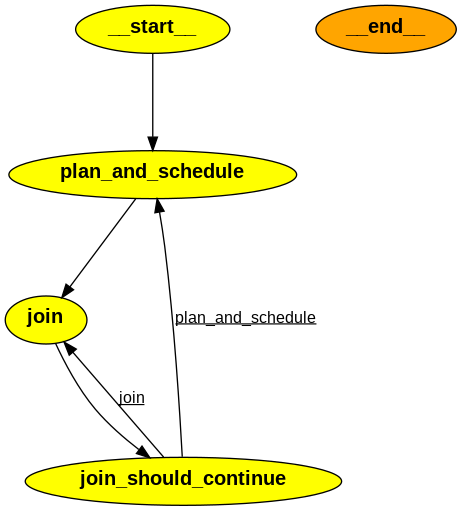

In [ ]:
from llmcompiler_.graph import chain

# chain.get_graph().print_ascii()
from IPython.display import Image
Image(chain.get_graph().draw_png())

In [2]:
!pip install pygraphviz

  Using cached pygraphviz-1.12.tar.gz (104 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.12-cp310-cp310-linux_x86_64.whl size=96873 sha256=d2bc7797a5f52bb579f4b24405439f515a8a728c31648c2748a30f5691e0f354
  Stored in directory: /home/amaithi/.cache/pip/wheels/1d/ee/b5/a2f54f9e9b3951599c05dcce270ca85e472f8e6cec470e397a
Successfully built pygraphviz


In [2]:
!poetry add grandalf


Using version ^0.8 for grandalf

Updating dependencies
Resolving dependencies... (0.6s)

Package operations: 2 installs, 0 updates, 0 removals

  • Installing pyparsing (3.1.2): Pending...
  • Installing pyparsing (3.1.2): Downloading... 0%
  • Installing pyparsing (3.1.2): Downloading... 100%
  • Installing pyparsing (3.1.2): Installing...
  • Installing pyparsing (3.1.2)
  • Installing grandalf (0.8): Pending...
  • Installing grandalf (0.8): Downloading... 0%
  • Installing grandalf (0.8): Downloading... 100%
  • Installing grandalf (0.8): Installing...
  • Installing grandalf (0.8)

Writing lock file


In [ ]:
from langgraph.prebuilt